In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim.lr_scheduler import StepLR

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import h5py
import matplotlib.pyplot as plt
# Check if CUDA (GPU support) is available
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("MPS is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("MPS is not available. Using CPU.")

MPS is available. Using GPU.


In [34]:
# Load and preprocess the data
def load_and_preprocess_data(file_path, reduced=750, rearrange=True):
    with h5py.File(file_path, 'r') as h5f:
        images = [h5f[img_name]["hist"][:].T[:,:reduced] for img_name in h5f.keys()]
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    rearranged_images = np.copy(images)
    for i in range(len(images)):
        images[i] = scaler.fit_transform(images[i])
        
        even_rows = images[i][0::2, :]  # Select even-numbered rows
        odd_rows = images[i][1::2, :]   # Select odd-numbered rows

        # Combine the even and odd row arrays to form the rearranged image
        rearranged_image = np.concatenate((even_rows, odd_rows), axis=0)
        rearranged_images[i] = rearranged_image
    return rearranged_images, images,scaler

# Prepare sequences and targets
def create_sequences_and_targets(images):
    sequences = []
    targets = []
    for img in images:
        for i in range(len(img) - seq_length):
            sequences.append(img[i:i + seq_length])
            targets.append(img[i + seq_length])
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Dataset and DataLoader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 256),  # Additional hidden layer
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, output_size)
        )
    
    def forward(self, x):
        output, _ = self.lstm(x)
        output = output[:, -1, :]  # Taking the last time step output
        output = self.dropout(output)
        output = self.fc_layers(output)
        output = torch.tanh(output)
        return output

In [35]:
def plot_images_side_by_side(ground_truth, predicted):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(ground_truth, cmap='viridis', origin='lower', aspect='auto')
    axes[0].set_title('Ground Truth')
    axes[1].imshow(predicted, origin='lower', aspect='auto', cmap='viridis')
    axes[1].set_title('Predicted')
    plt.show

In [56]:
# Hyperparameters
batch_size = 32
num_epochs = 200
learning_rate = 0.01# #initial learning rate for scheduler #0.00004
input_size = 750#2048
hidden_size = 128
output_size = 750#2048
seq_length = 8  # Number of previous rows to consider


In [40]:
# Load and preprocess data
data_file = '../lstm_data2_simdata.h5'  # Replace with the actual path to your HDF5 file
re_images,images,scaler = load_and_preprocess_data(data_file)

# # # Create sequences and targets
sequences, targets = create_sequences_and_targets(re_images)


/var/folders/c_/vs55dp4d3lg5_1fzlmjf9_9xjbg4mn/T/ipykernel_74593/1773708749.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1691912374495/work/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


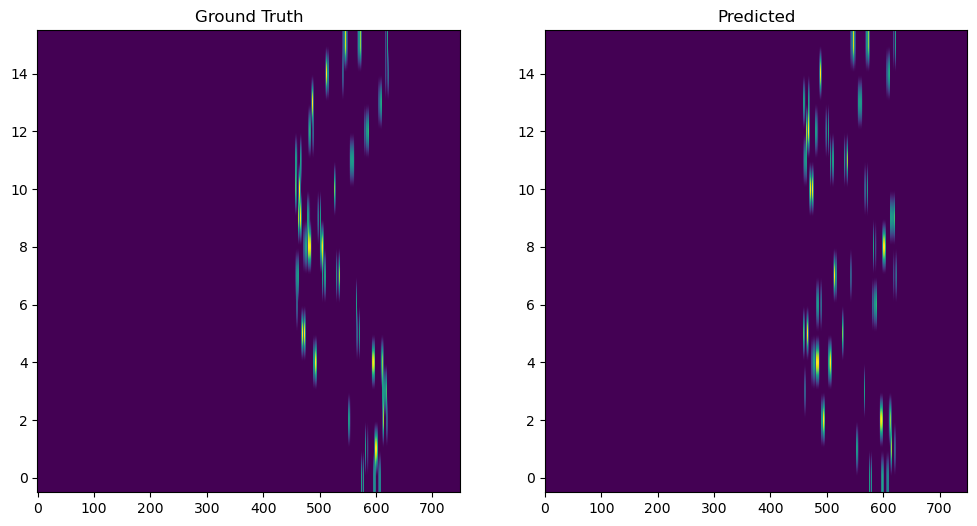

In [39]:
plot_images_side_by_side(images[1], re_images[1])


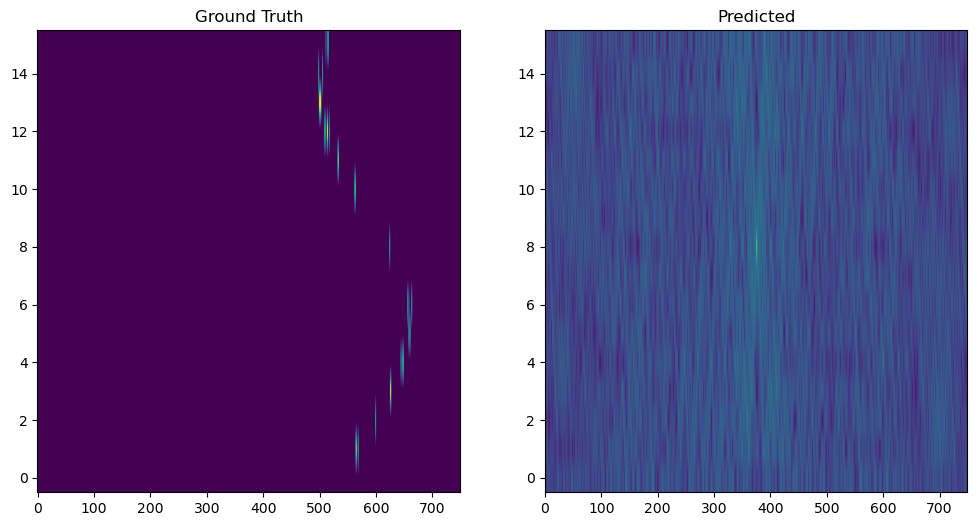

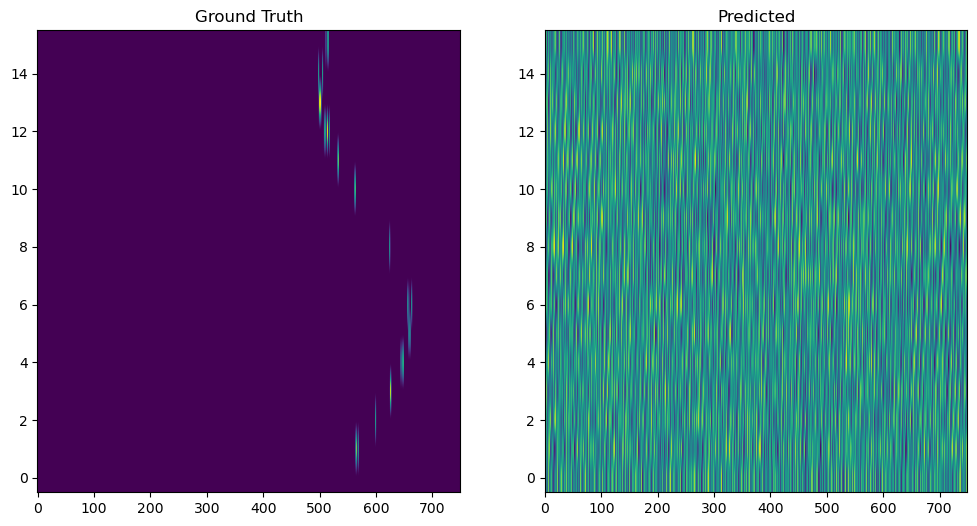

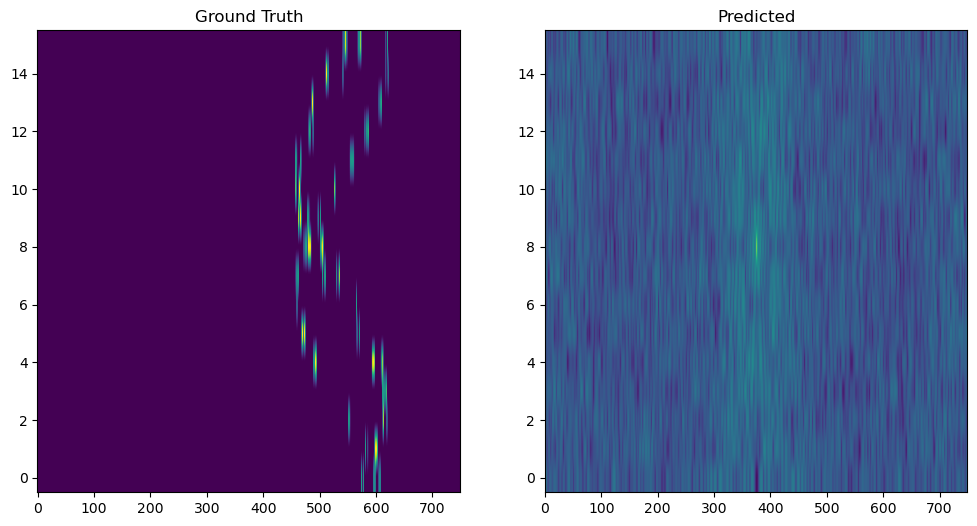

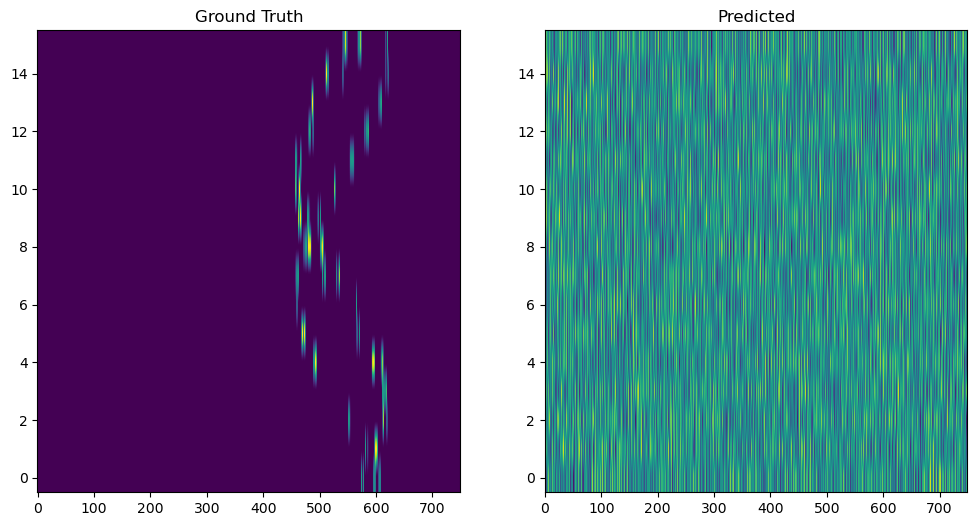

In [77]:
# Assuming 'image' is your NumPy array representing the image
# Compute the 2D Fourier transform
f_transform = np.fft.fft2(images[10])

# Shift the zero frequency component to the center
f_transform_shifted = np.fft.fftshift(f_transform)

# Compute the magnitude spectrum
magnitude_spectrum = np.abs(f_transform_shifted)
phase_spectrum = np.angle(f_transform_shifted)

plot_images_side_by_side(images[10], np.log(magnitude_spectrum + 1))
plot_images_side_by_side(images[10], phase_spectrum)

# Assuming 'image' is your NumPy array representing the image
# Compute the 2D Fourier transform
f_transform = np.fft.fft2(images[1])

# Shift the zero frequency component to the center
f_transform_shifted = np.fft.fftshift(f_transform)

# Compute the magnitude spectrum
magnitude_spectrum = np.abs(f_transform_shifted)
phase_spectrum = np.angle(f_transform_shifted)

plot_images_side_by_side(images[1], np.log(magnitude_spectrum + 1))
plot_images_side_by_side(images[1], phase_spectrum)




In [61]:
images[1].shape


(16, 750)

In [57]:
# # Create DataLoader
dataset = CustomDataset(sequences, targets)
train_size = int(0.8 * len(dataset))
val_size = int((len(dataset) - train_size) // 1.5)
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Initialize the model
model = LSTMModel(input_size, hidden_size, output_size, num_layers=4, dropout_prob=.3)
model.to(device)
# # Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Define the learning rate scheduler
# StepLR will reduce the learning rate by a factor (gamma) every 'step_size' epochs
step_size = 5  # Adjust this according to your preference
gamma = 0.5  # Adjust this according to your preference
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

In [58]:
# Lists to store training and validation losses
train_losses = []
val_losses = []

#Initialize variables for early stopping
best_train_loss = 1000
patience = 10  # Number of epochs without improvement to wait before stopping
min_loss_change = 0.001  # Half a percent change threshold
early_stopping_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch_sequences, batch_targets in train_dataloader:
        batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
        optimizer.zero_grad()
        
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_targets)
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(train_loss)
    
    loss_change = (best_train_loss-train_loss)/best_train_loss
    # Check if training loss has improved
    print(loss_change)
    if loss_change >= min_loss_change:
        best_train_loss = train_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Check if early stopping criteria are met
    if early_stopping_counter >= patience:
        print(f"Early stopping triggered. Best training loss: {best_train_loss}")
        break
        
    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for batch_sequences, batch_targets in val_dataloader:
            batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_targets)
            total_val_loss += loss.item()
        
        val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    final_num_epochs = epoch
    
    # Update the learning rate
    scheduler.step()
    
    # Print the current learning rate (optional)
    print(f"Epoch {epoch+1}, Learning Rate: {optimizer.param_groups[0]['lr']}")
print("Training finished!")


0.9999729336823578
Epoch [1/200], Train Loss: 0.0271, Val Loss: 0.0259
Epoch 1, Learning Rate: 0.01
0.03315949449845508
Epoch [2/200], Train Loss: 0.0262, Val Loss: 0.0259
Epoch 2, Learning Rate: 0.01
2.491231661027275e-10
Epoch [3/200], Train Loss: 0.0262, Val Loss: 0.0259
Epoch 3, Learning Rate: 0.01
-2.491231661027275e-10
Epoch [4/200], Train Loss: 0.0262, Val Loss: 0.0259
Epoch 4, Learning Rate: 0.01
-4.6265736529626185e-10
Epoch [5/200], Train Loss: 0.0262, Val Loss: 0.0259
Epoch 5, Learning Rate: 0.005
-5.338354316941066e-10
Epoch [6/200], Train Loss: 0.0262, Val Loss: 0.0259
Epoch 6, Learning Rate: 0.005
1.4235613279568954e-10
Epoch [7/200], Train Loss: 0.0262, Val Loss: 0.0259
Epoch 7, Learning Rate: 0.005
2.1353419919353432e-10
Epoch [8/200], Train Loss: 0.0262, Val Loss: 0.0259
Epoch 8, Learning Rate: 0.005
9.609038300811753e-10
Epoch [9/200], Train Loss: 0.0262, Val Loss: 0.0259
Epoch 9, Learning Rate: 0.005
-3.55889669091932e-11
Epoch [10/200], Train Loss: 0.0262, Val Loss:

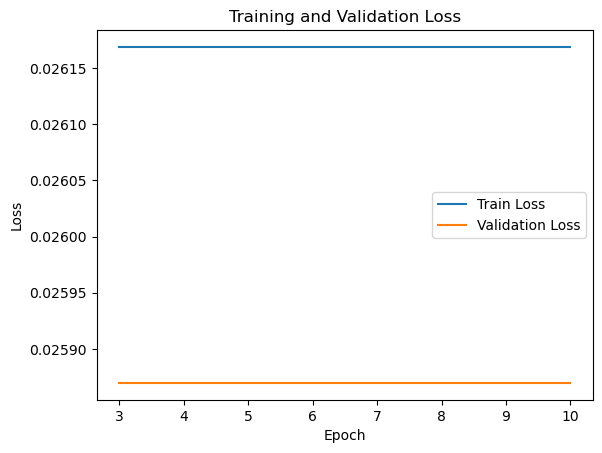

In [59]:
# final_num_epochs = 200
# Plotting training and validation losses
plt.plot(range(3, final_num_epochs + 1), train_losses[2:final_num_epochs], label='Train Loss')
plt.plot(range(3, final_num_epochs + 1), val_losses[2:final_num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'lstm_model_rearranged.pth')

<function matplotlib.pyplot.show(close=None, block=None)>

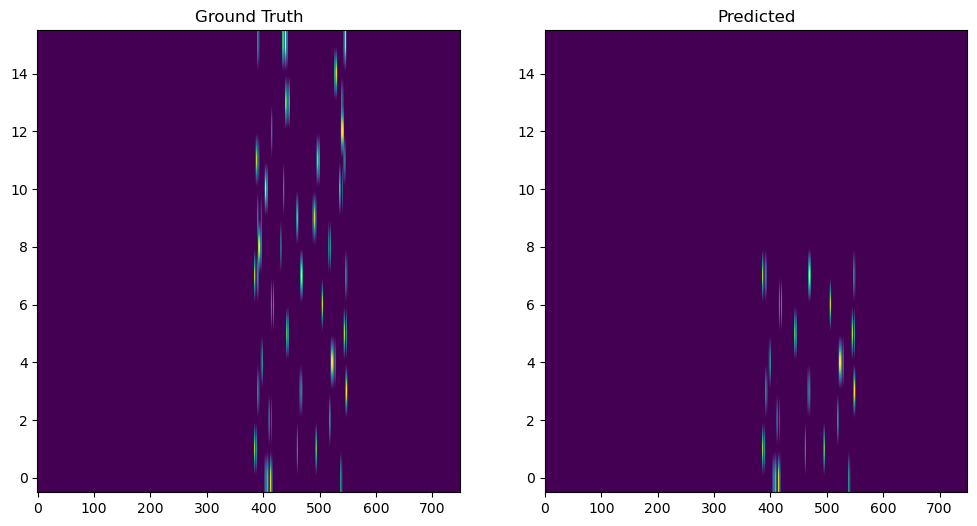

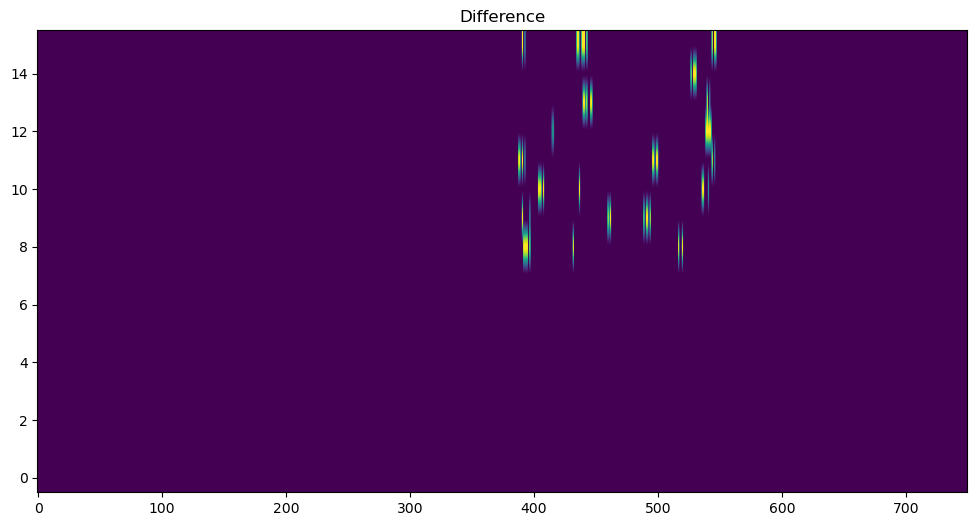

In [55]:
# Load the trained model
model = LSTMModel(input_size, hidden_size, output_size,num_layers=4, dropout_prob=0)
model.to(device)
model.load_state_dict(torch.load('lstm_model_rearranged.pth'))
model.eval()
# file_path = "../lstm_data_simdata.h5"
# with h5py.File(file_path, 'r') as h5f:
#     new_images = [h5f[img_name]["hist"][:].T for img_name in h5f.keys()]
# for i in range(len(new_images)):
#     new_images[i] = scaler.transform(new_images[i])
new_images = re_images  

new_example_image_normalized= new_images[12]
# Take the first 8 rows from the new example image
initial_input = torch.tensor(new_example_image_normalized[:8], dtype=torch.float32)
initial_input_full = torch.tensor(new_example_image_normalized, dtype=torch.float32)
# Predict the remaining 8 rows using the LSTM model
with torch.no_grad():
    predicted_rows = initial_input.clone()
    for i in range(seq_length, 16):
        input_seq = predicted_rows[i - seq_length:i].unsqueeze(0)  # Add a batch dimension
        input_seq = input_seq.to(device)
        predicted_row = model(input_seq)
        predicted_row = predicted_row.to('cpu')
        predicted_rows = torch.cat((predicted_rows, predicted_row), dim=0)
        
# Plot the ground truth and predicted images side by side
def plot_images_side_by_side(ground_truth, predicted):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(ground_truth, cmap='viridis', origin='lower', aspect='auto')
    axes[0].set_title('Ground Truth')
    axes[1].imshow(predicted, origin='lower', aspect='auto', cmap='viridis')
    axes[1].set_title('Predicted')
    plt.show
    
# Plot the images
ground_truth = initial_input_full
predicted_image = predicted_rows.detach().numpy()

plot_images_side_by_side(ground_truth, predicted_image)
# # Predict the remaining 8 rows using the LSTM model
# with torch.no_grad():
#     predicted_rows = initial_input.clone()
#     for i in range(seq_length, output_size):
#         input_seq = predicted_rows[i - seq_length:i].unsqueeze(0)  # Add a batch dimension
#         predicted_row = model(input_seq)
#         predicted_rows = torch.cat((predicted_rows, predicted_row), dim=0)

# # Plot the ground truth and predicted images side by side
# def plot_images_side_by_side(ground_truth, predicted):
#     fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#     axes[0].imshow(ground_truth.T, cmap='viridis', origin='lower', aspect='auto')
#     axes[0].set_title('Ground Truth')
#     axes[1].imshow(predicted.T, cmap='viridis', origin='lower', aspect='auto')
#     axes[1].set_title('Predicted')
#     plt.show()

# # Plot the images
# ground_truth = targets[0:8]
# predicted_image = predicted_rows[8:].numpy()

# plot_images_side_by_side(ground_truth.T, predicted_image.T)


fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.imshow((ground_truth-predicted_image), cmap='viridis', origin='lower', aspect='auto')
axes.set_title('Difference')
plt.show

In [ ]:
ground_truth